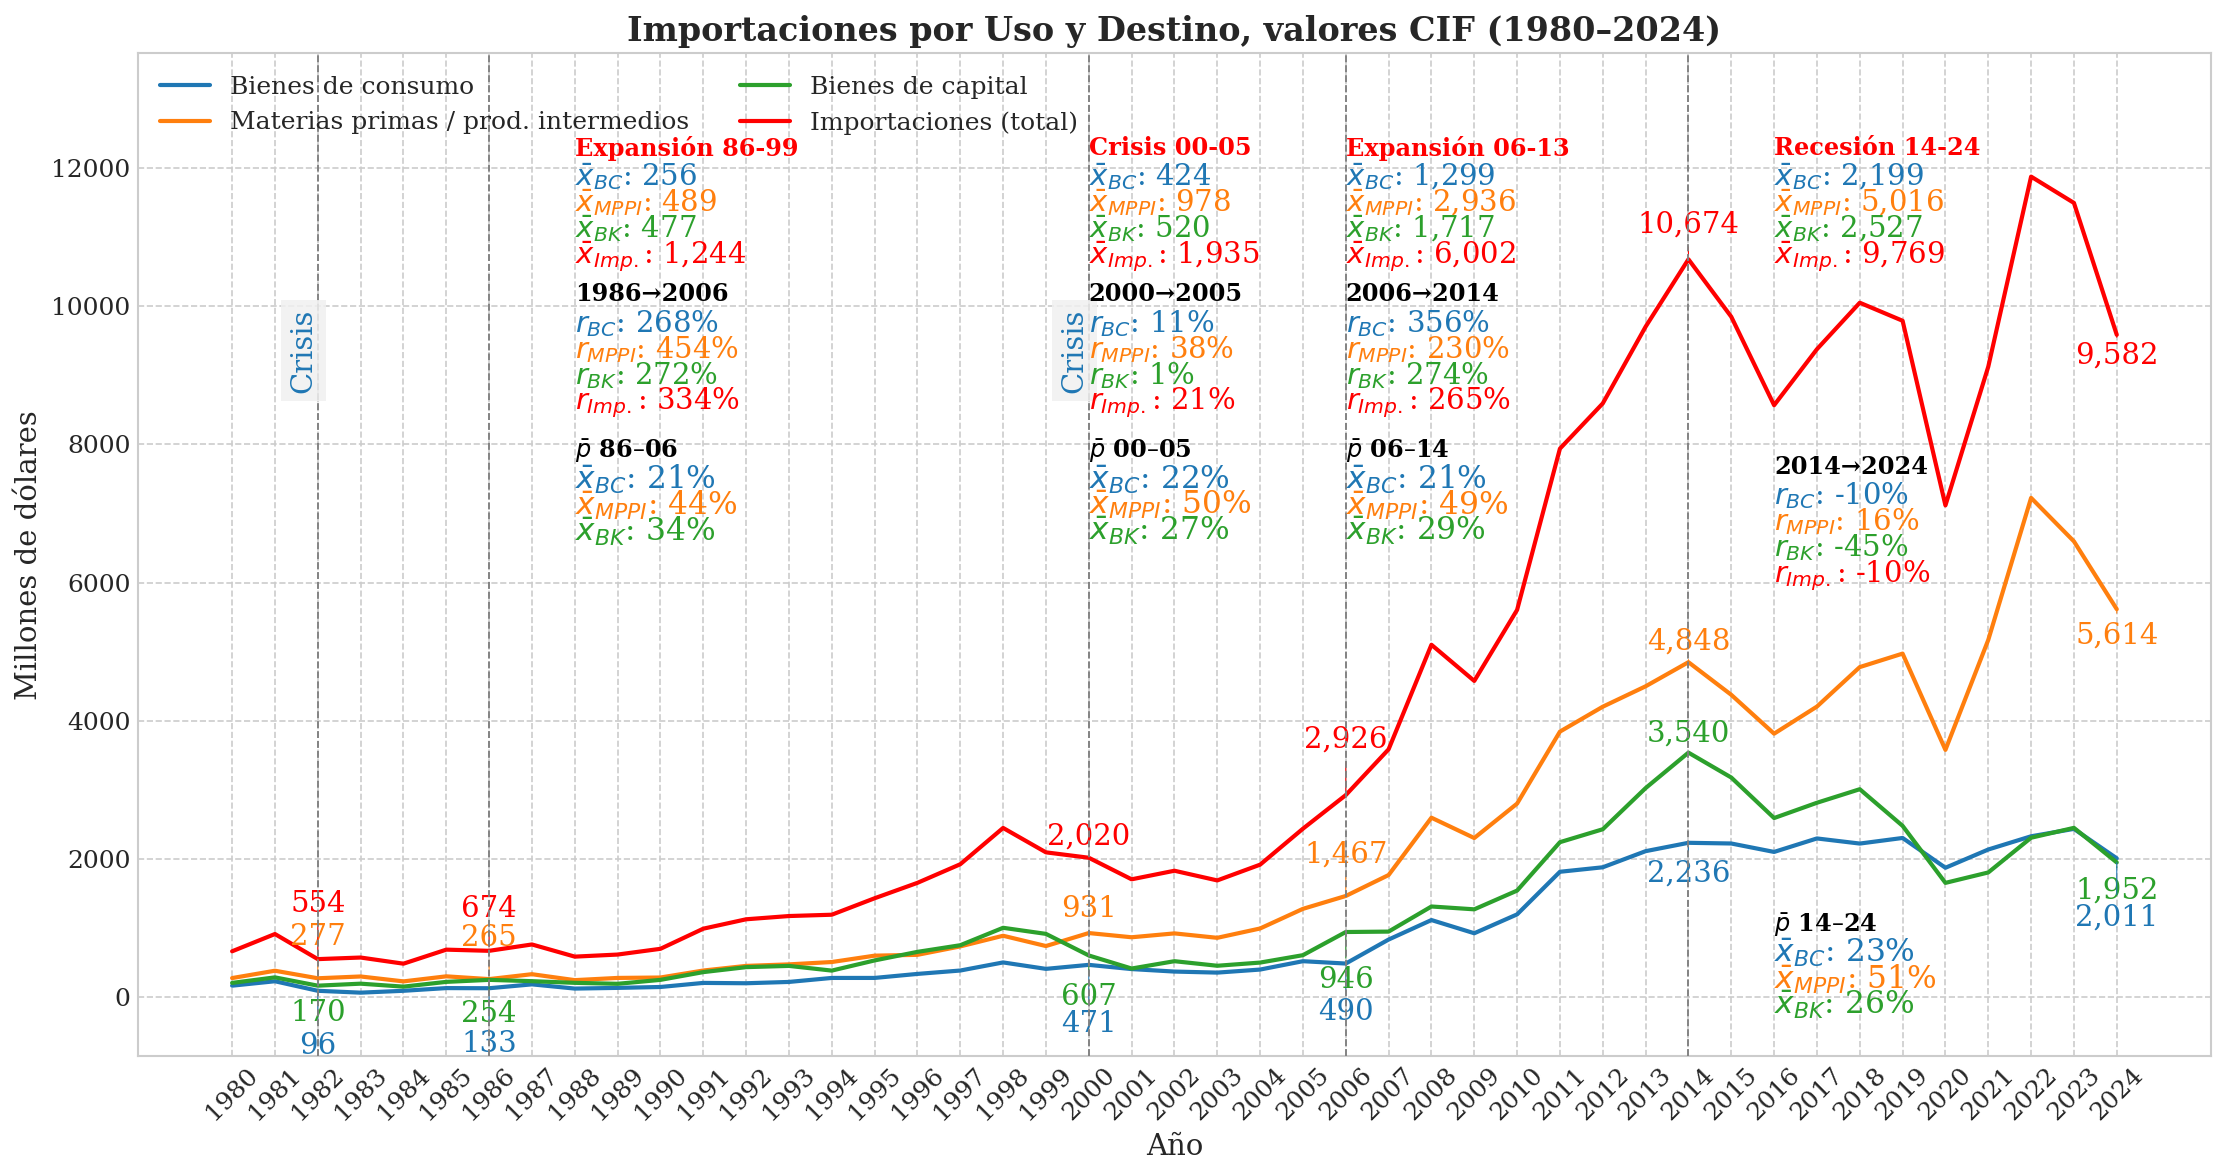

In [2]:
# ──────────────────────────── IMPORTS ──────────────────────────────
import sys, os, sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath('../'))          # utilidades propias
from graficos_utils import (
    add_hitos, add_cycle_means_multi,
    add_year_value_annotations, add_period_growth_annotations_multi, add_participation_cycle_boxes
)

# ── 0.  Tramos de ciclo ─────────────────────────────────────────────
CRISIS_82_85      = slice(1982, 1985)
EXPANSION_86_99   = slice(1986, 1999)
CRISIS_00_05      = slice(2000, 2005)
ACUMULACION_06_13 = slice(2006, 2013)
RECESION_14_24    = slice(2014, 2024)

periods = {
    "Expansión 86-99": EXPANSION_86_99,
    "Crisis 00-05": CRISIS_00_05,
    "Expansión 06-13": ACUMULACION_06_13,
    "Recesión 14-24":  RECESION_14_24,
}

# ── 1. Configuración general ───────────────────────────────────────
output_dir = "../../../../assets/tesis/serie_completa/importaciones"
os.makedirs(output_dir, exist_ok=True)

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.family': 'serif', 'font.size': 12,
    'axes.titlesize': 16,   'axes.labelsize': 14,
    'grid.linestyle': '--', 'lines.linewidth': 2,
    'figure.dpi': 150,      'savefig.bbox': 'tight'
})

# ── 2. Carga de datos (valores absolutos) ───────────────────────────
with sqlite3.connect('../../../../db/proyectomacro.db') as conn:
    df = (pd.read_sql('SELECT * FROM composicion_importaciones_uso_destino', conn)
            .set_index('año')
            .sort_index())
    df.rename(columns={'total_valor_oficial_cif': 'importaciones'}, inplace=True)

component_cols = [
    'bienes_consumo',
    'materias_primas_productos_intermedios',
    'bienes_capital',
    'importaciones'
]

# ── 3. Estadísticas por ciclo ───────────────────────────────────────
cycle_stats = {
    name: df.loc[period, component_cols].mean().to_dict()
    for name, period in periods.items()
}

# ── 4. Hitos y offsets ──────────────────────────────────────────────
hitos_v      = {1982:"Crisis", 1986:"Expansión", 2000:"Crisis",
                2006:"Expansión", 2014:"Recesión"}
hitos_offset = {a:0.8 for a in hitos_v}

medias_offset = {
    "Expansión 86-99": (1988, 1),
    "Crisis 00-05": (2000, 1),
    "Expansión 06-13": (2006, 1),
    "Recesión 14-24":  (2016, 1),
}

anot_years = [1982, 1986, 2000, 2006, 2014, 2024]
annotation_offsets = {
    'bienes_consumo': {
        1982: (0, -800),
        1986: (0, -800),
        2000: (0, -850),
        2006: (0, -700),
        2014: (0, -450),
        2024: (0, -850),
    },
    'materias_primas_productos_intermedios': {
        1982: (0,  600),
        1986: (0,  600),
        2000: (0,  350),
        2006: (0,  600),
        2014: (0,  300),
        2024: (0,  -380),
    },
    'bienes_capital': {
        1982: (0, -400),
        1986: (0, -500),
        2000: (0, -600),
        2006: (0, -700),
        2014: (0, 280),
        2024: (0, -400),
    },
    'importaciones': {
        1982: (0,  800),
        1986: (0, 600),
        2000: (0, 300),
        2006: (0, 800),
        2014: (0, 500),
        2024: (0, -300),
    },
}


annotation_tasas_offsets = {
    "1986-2006": (1988, 0.83),
    "2000-2005": (2000, 0.83),
    "2006-2014": (2006, 0.83),
    "2014-2024": (2016, 0.63),
}
participation_offsets = {
    "1986-2006": (1988, 0.65),
    "2000-2005": (2000, 0.65),
    "2006-2014": (2006, 0.65),
    "2014-2024": (2016, 0.1),
}
# ── 5. Gráfico ──────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(15, 8))

color_map = {
    'bienes_consumo': '#1f77b4',
    'materias_primas_productos_intermedios': '#ff7f0e',
    'bienes_capital': '#2ca02c',
    'importaciones': 'red',
}
labels_map = {
    'bienes_consumo': 'Bienes de consumo',
    'materias_primas_productos_intermedios': 'Materias primas / prod. intermedios',
    'bienes_capital': 'Bienes de capital',
    'importaciones': 'Importaciones (total)',
}   

for col in component_cols:
    ax.plot(df.index, df[col], label=labels_map[col], color=color_map[col])

# ── 6. Hitos ────────────────────────────────────────────────────────
add_hitos(ax, df.index, hitos_v, hitos_offset, line_kwargs={'linewidth':0.9})

# ── 7. Anotaciones de medias, valores y tasas ───────────────────────
abbr_map = {'bienes_consumo':'BC', 'materias_primas_productos_intermedios':'MPPI',
            'bienes_capital':'BK', 'importaciones':'Imp.'}
component_colors = color_map
y_max = ax.get_ylim()[1]
line_spacing = y_max * 0.03

add_cycle_means_multi(ax, cycle_stats, medias_offset,
                      abbr_map, component_colors, line_spacing)

add_year_value_annotations(ax, df, anot_years,
                           component_cols, annotation_offsets,
                           component_colors, arrow_lw=0.5)

# ── 7.1  Copia segura para tasas (evita división por cero) ──────────
df_g = df.replace(0, np.nan)   # evita OverflowError

periodos = [(1986, 2006), (2000, 2005), (2006, 2014), (2014, 2024)]
add_period_growth_annotations_multi(ax, df_g, periodos,
    component_cols, annotation_tasas_offsets,
    component_colors, abbr_map)

add_participation_cycle_boxes(
    ax,
    df,
    periodos,
    ['bienes_consumo', 'materias_primas_productos_intermedios', 'bienes_capital'],              
    'importaciones',     
    participation_offsets,
    abbr_map=abbr_map,
    colors=component_colors
)

    

# ── 8. Ajustes finales ──────────────────────────────────────────────
ax.set_title("Importaciones por Uso y Destino, valores CIF (1980–2024)",
             fontweight='bold')
ax.set_xlabel("Año")
ax.set_ylabel("Millones de dólares")
ax.set_xticks(df.index[::max(1, len(df)//31)])
ax.tick_params(axis='x', rotation=45)
ax.legend(loc='upper left', fontsize=12, ncol=2)

ax.set_ylim(-850, df[component_cols].max().max()*1.15)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "importaciones_uso_destino_valores.png"))
plt.show()
